## https://arxiv.org/pdf/1301.5962.pdf

In [487]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import timeit
from tqdm import tqdm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [521]:
# assum x is matrix (n,m) in range [0,1]
# n - number of sumples 
# m - number of variables

def rosenbrock(x, a=100):
    # normalize to [-2,2]
    x = (x - 0.5) * 4
    res = (a * (x[:,:-1]**2 - x[:,1:])**2 + (x[:,:-1] - 1)**2).sum(1)
    return res 

def rastrigin(x):
    # normalize to [-5.12,5.12]
    x = (x - 0.5) * 10.24
    return (x ** 2 - 10 * torch.cos(2 * np.pi * x) + 10).sum(1)


# x0^2 + x1^2 + ... + xn^2
def f0(x):
    res = (x**2).sum(1)
    return res

# sum((x_j + x_j+1)^2)
def f1(x):
    res = ((x[:,:-1] + x[:,1:])**2).sum(1)
    return res


# sum((x_j * x_j+1)^2)
def f2(x):
    res = ((x[:,:-1] * x[:,1:])**2).sum(1)
    return res


# (x0 + x1 + ... + xn)^2
def f3(x):
    res = x.sum(1)**2
    return res


def separability_cond(f, m, n, gpu=False):
    x, z = torch.tensor(np.random.uniform(0, 1, size=(n, m))), torch.tensor(np.random.uniform(0, 1, size=(n, m)))
    if gpu:
        x = x.cuda()
        z = z.cuda()

    t1 = f(x) + (m - 1)*f(z)

    t2 = t1.new_zeros((n,))
    for i in range(m):
        y = z.clone()
        y[:,i] = x[:,i]
        t2 += f(y)

    g = f(x) * (t1 - t2)
    gamma = g.mean()

    s = (g - gamma).std()
    T = np.sqrt(n) * gamma / max(s, 1e-12)

    return gamma, T

In [382]:
print("GPU time: {:.3f}s".format(timeit.timeit(lambda : separability_cond(rosenbrock, 50, 10**6, gpu=True), number=1)))
print("CPU time: {:.3f}s".format(timeit.timeit(lambda : separability_cond(rosenbrock, 50, 10**6), number=1)))

GPU time: 2.788s
CPU time: 31.044s


In [380]:
n = 10**3
gamma, T = separability_cond(f0, 10, n, gpu=True)
print("gamma^2: {:.5f}".format(gamma))
print("T': {:.4f}".format(T))
print("T norm: {:.8f}".format(T / np.sqrt(n)))

gamma^2: -0.00000
T': -0.0043
T norm: -0.00013723


In [475]:
n = 10**4
gamma, T = separability_cond(f3, 10, n, gpu=True)
print("gamma^2: {:.5f}".format(gamma))
print("T': {:.4f}".format(T))
print("T norm: {:.8f}".format(T / np.sqrt(n)))

gamma^2: 2.32340
T': 3.2066
T norm: 0.03206603


In [544]:
N = np.arange(1, 100) * 10**4

gamma_arr=[]; T_arr=[]
for i in tqdm(N):
    gamma, T = separability_cond(rosenbrock, 5, i, gpu=True)
    gamma_arr.append(gamma.item())
    T_arr.append(T.item())

100%|██████████| 99/99 [00:07<00:00, 13.04it/s]


304237.3339626933


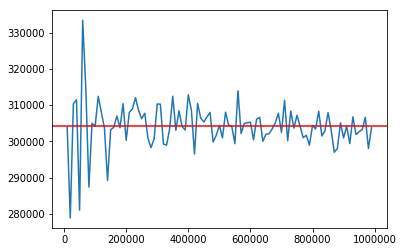

0.10152520916351108


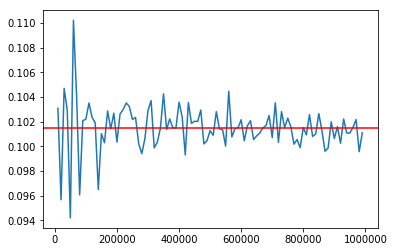

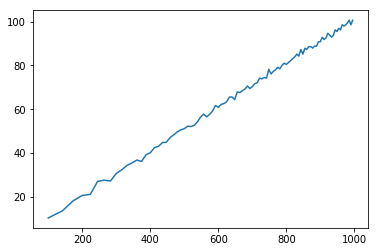

In [545]:
print(np.mean(gamma_arr))
plt.plot(N, gamma_arr)
plt.axhline(np.mean(gamma_arr), c='r')
plt.show()
Tnorm = T_arr / np.sqrt(N)
print(np.mean(Tnorm))
plt.plot(N, Tnorm)
plt.axhline(np.mean(Tnorm), c='r')
plt.show()
plt.plot(np.sqrt(N), T_arr)

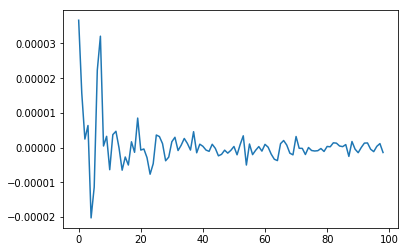

In [543]:
plt.plot(T_arr/N)